In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

from collections import Counter, defaultdict

In [ ]:
## From the project
# ========== Feature Extractor (Color Histogram + HOG) ==========
def extract_features(image, bins=32, resize_dim=(64, 64)):
    image = image.resize(resize_dim).convert('RGB') # Ensures that all images are RGB
    image_np = np.array(image)
    hist_r = np.histogram(image_np[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image_np[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image_np[:, :, 2], bins=bins, range=(0, 256))[0]
    hist = np.concatenate([hist_r, hist_g, hist_b])
    return hist / np.sum(hist)

def extract_hog_features(image, resize_dim=(64, 64), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    image = image.resize(resize_dim).convert('RGB')
    gray = rgb2gray(np.array(image))
    features = hog(gray, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys')
    return features

def extract_combined_features(image):
    hog_feat = extract_hog_features(image)
    hist_feat = extract_features(image)
    return np.concatenate([hog_feat, hist_feat])

In [ ]:
# Data extraction from the project
# Parameters
image_size = (64, 64)  # Resize all images to 64x64
valid_exts = ('.jpg', '.jpeg', '.png')

# Function to load images from a given folder
def load_dataset(root_dir, extractor_fn):
    X = []
    y = []
    class_names = sorted(os.listdir(root_dir))
    for label in class_names:
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for fname in os.listdir(label_path):
            if fname.lower().endswith(valid_exts):
                try:
                    img_path = os.path.join(label_path, fname)
                    img = Image.open(img_path).convert('RGB')
                    if extractor_fn == None:
                        img = img.resize(image_size)
                        img_array = np.array(img).flatten()  # Flatten to 1D vector (64*64*3)
                        X.append(img_array)
                        y.append(label)
                    else:
                        features = extractor_fn(img)
                        X.append(features)
                        y.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    return np.array(X), np.array(y)

# Load training and testing data
print("=== Load data ===")
func_name = None #extract_features #extract_combined_features #None
X_train, y_train = load_dataset("/Users/shurrab/Library/CloudStorage/OneDrive-Personal/PhD Concordia/Courses/COMP6721 Applied AI/Project/Phase I/Training", func_name)
X_test, y_test = load_dataset("/Users/shurrab/Library/CloudStorage/OneDrive-Personal/PhD Concordia/Courses/COMP6721 Applied AI/Project/Phase I/Test", func_name)

# Encode labels (e.g., 'library' -> 0, etc.)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Shuffle and standardize
X_train, y_train_enc = shuffle(X_train, y_train_enc, random_state=42)
X_test, y_test_enc = shuffle(X_test, y_test_enc, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Classes: {le.classes_}")

=== Load data ===
Train shape: (15000, 12288), Test shape: (300, 12288)
Classes: ['library-indoor' 'museum-indoor' 'shopping_mall-indoor']


In [15]:
kmeans = KMeans(n_clusters=3, random_state=6721, init='k-means++', n_init='auto')
kmeans.fit(X_train)

/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountere

KMeans(n_clusters=3, random_state=6721)

In [16]:
y_kmeans = kmeans.labels_

In [ ]:
from collections import Counter, defaultdict
all_clusters = np.zeros((3,3,1))

cluster_label_counts = defaultdict(Counter)

for cluster_id, true_label in zip(y_kmeans, y_train_enc):
    cluster_label_counts[cluster_id][true_label] += 1

# Print snapshot
for cluster_id, counter in cluster_label_counts.items():
        # print(f"\nCluster {cluster_id}:")
        for label, count in counter.items():
            all_clusters[cluster_id][label]= count
            l = le.inverse_transform([label])
            # print(f"  {l}: {count}")
print("Extracted features using Color Histogram + HOG")

for i in range(len(all_clusters)):
    print(f"\nCluster {i}:")
    for j in range(len(all_clusters[i])):
        l = le.inverse_transform([j])
        print(l, ":\t", all_clusters[i][j][0])

Extracted features using Color Histogram + HOG

Cluster 0:
['library-indoor'] :	 930.0
['museum-indoor'] :	 1585.0
['shopping_mall-indoor'] :	 1416.0

Cluster 1:
['library-indoor'] :	 1932.0
['museum-indoor'] :	 2099.0
['shopping_mall-indoor'] :	 1267.0

Cluster 2:
['library-indoor'] :	 2138.0
['museum-indoor'] :	 1316.0
['shopping_mall-indoor'] :	 2317.0


In [18]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_train_enc, y_kmeans)
nmi = normalized_mutual_info_score(y_train_enc, y_kmeans)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 0.0235
Normalized Mutual Information (NMI): 0.0223


/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/shurrab/miniconda3/envs/sim/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountere

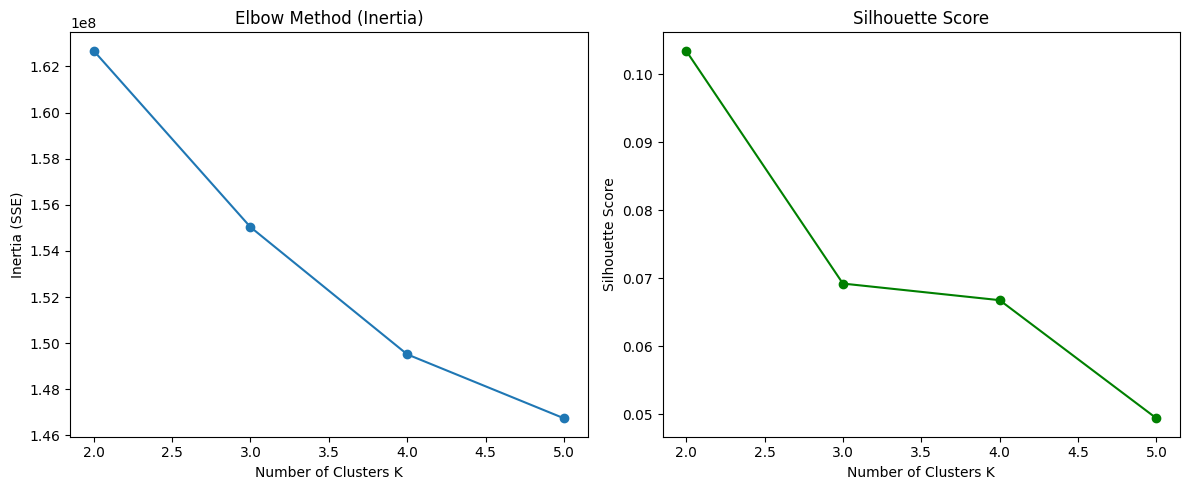

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



inertias = []
silhouettes = []
Ks = [2, 3, 4, 5]

for k in Ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=6721, n_init='auto')
    y_pred = kmeans.fit_predict(X_train)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_train, y_pred))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters K")
plt.ylabel("Inertia (SSE)")


plt.subplot(1, 2, 2)
plt.plot(Ks, silhouettes, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters K")
plt.ylabel("Silhouette Score")


plt.tight_layout()
plt.show()
